# Objectif : minimiser le max de la puissance à la racine dans une journée

### Librairies

In [1]:
import pandas as pd
from math import isnan, exp
import numpy as np
from random import randint, uniform, sample
import matplotlib.pyplot as plt
import datetime
from time import time

### Ouverture des fichiers

In [2]:
file_name_power_limits = "data_opti/limites_puissance.csv"
file_name_consumption_info = "data_opti/info_consommation.csv"
file_name_equipments = "data_opti/equipements.csv"

# Création des df
df_power_limits = pd.read_csv(file_name_power_limits, sep = ';')
df_info_consumption = pd.read_csv(file_name_consumption_info, sep = ';', index_col = 0, decimal = ",")
df_equipments = pd.read_csv(file_name_equipments, sep = ';', index_col = 0, decimal = ",")

# Liste des noms d'équipements et des id de maison
lst_index_logement = list(df_equipments.index.values)
lst_col_equipment = list(df_equipments.columns.values)

# Contraintes Heures creuses
dict_HC = {
    "range1" : {"begin" : "22", "end" : "7"},
    "range2" : {"begin" : '10', "end" : '14'}
}

### Lecture fichier

In [3]:
df_power_limits.head(10)

,min_surface,max_surface,puissance
0,NaN,50.0,3
1,50.0,80.0,6
2,80.0,100.0,9
3,100.0,160.0,12
4,160.0,180.0,15
5,180.0,200.0,25
6,200.0,250.0,30
7,250.0,NaN,36


In [4]:
df_info_consumption.head(10)

,type,puissance,tps_cycle,amperage,hr_debut_hc,hr_debut_hc_nb,hr_max,sequensable
LV,Md1,1.3,1.0,6.0,0,NaN,NaN,N
LL,Md2,2.0,1.0,9.0,0,NaN,NaN,N
SL,Md3,1.0,4.0,4.0,0,NaN,NaN,N
TV,Md4,0.1,1.0,0.5,1,1.0,NaN,N
FG1,Mc1,0.1,0.2,0.5,1,4.0,NaN,N
CE1,Mc2,2.2,6.0,10.0,1,1.0,NaN,O
CG,Mc3,0.1,0.2,0.5,1,4.0,NaN,N
FO,Md5,1.6,1.0,12.0,1,1.0,NaN,N
PL,Md6,1.2,1.0,20.0,1,1.0,NaN,N
FG2,Mc4,0.3,0.2,3.0,1,4.0,NaN,N


In [5]:
df_equipments.head(7)

,LV,LL,SL,TV,FG1,CE1,CG,FO,PL,FG2,CE2
A100-3-1,1,1,1,1,1,1,0,1,1,1,1
A100-3-10,1,1,1,1,1,1,0,1,1,1,0
A100-3-100,1,1,1,1,1,1,0,1,1,0,0
A100-3-101,1,1,0,1,1,1,1,1,1,0,1
A100-3-102,1,1,1,1,1,1,0,1,1,0,0
A100-3-103,1,1,1,1,1,1,1,1,1,1,0
A100-3-104,1,1,0,1,1,1,0,1,1,0,0


### Tester sur un plus petit jeu de données

In [6]:
#df_equipments_short = df_equipments[:10000]
df_equipments_short = df_equipments[:]
lst_index_logement = list(df_equipments_short.index.values)
lst_col_equipment = list(df_equipments_short.columns.values)

### Fonctions

In [7]:
# Parse le nom de chaque maison Mxxx-yy-zzz ou appartement Axxx-yy-zzz ou 
#    - Xxx : surface (m²)
#    - Yy : nb occupants
#    - Zzz : repère sur le réseau
def parse_name(lst_name_housing : str) -> dict :
    res = {'type' : [], "surface" : [], "occupants" : [], "id" : []}
    
    for str_id in lst_name_housing:
        name_housing = str_id
        if name_housing[0] == "A" : res['type'].append('appartement')
        else : res['type'].append("maison")

        # Surface m²
        name_housing = name_housing[1:]
        stop = name_housing.find("-")
        res["surface"].append(int(name_housing[:stop]))

        # Nb occupants
        name_housing = name_housing[stop + 1:]
        stop = name_housing.find("-")
        res["occupants"].append(int(name_housing[:stop]))

        # Id 
        res["id"].append(name_housing[stop + 1:])
    
    return res

In [8]:
# quand des horaires empiètent sur les journées précédentes, on découpe en deux blocs
def modif_creneau(dict_HC : dict) -> dict :
    new_dict_HC = {}
    i = 1
    for key in dict_HC:
        start = int(dict_HC[key]["begin"])
        stop = int(dict_HC[key]["end"])
        if start > stop :
            new_dict_HC["range" + str(i)] = {"begin" : start, "end" : 23}
            i += 1
            new_dict_HC["range" + str(i)] = {"begin" : 0, "end" : stop}
        else :
            new_dict_HC["range" + str(i)] = {"begin" : start, "end" : stop}
        i += 1
    return(new_dict_HC)

In [9]:
# Définit la consommation max selon la surface en m²
def max_consumption(df_limits, surface) -> int :
    for index, row in df_limits.iterrows():
        bool1 = (row["min_surface"] < surface) if not(isnan(row["min_surface"])) else True
        bool2 = (surface <= row["max_surface"]) if not(isnan(row["max_surface"])) else True
        if bool1 and bool2 : return row["puissance"]
    return None

In [10]:
# choisit un début selon les heures creuses et le temps du cycle
def compute_nb_tot_hc(dict_hc_ : dict, tps_cycle) -> int :                       
    tmp = {}
    i = 0
    for key in dict_hc_:
        start, stop = int(dict_hc_[key]["begin"]), int(dict_hc_[key]["end"])
        if stop - start + 1 >= tps_cycle:  
            tmp[i] = [j for j in range(start, stop + 1)]
            i += 1
    randint_range = randint(0, len(tmp.keys()) - 1) if len(tmp.keys()) > 1 else 0
    index_rand_first = randint(tmp[randint_range][0], tmp[randint_range][-1] - tps_cycle)
    del tmp    
    return index_rand_first

# List of "heures creuses"
def create_list_hc(dict_HC : dict) -> list :
    res = []
    for key in dict_HC:
        for j in range(dict_HC[key]["begin"], dict_HC[key]["end"] + 1):
            res.append(j)
    return res

In [11]:
# Création de l'index selon l'équipement
def case_hr(res, dict_hc_, df_info_consumption, df_equipment, current_equipment, tps_cycle, str_indiv, power_per_tps):    
    ite, ite_max = 0, 1000
    bool_index_ok = False
            
    while (not(bool_index_ok) and ite < ite_max):              
        # Cas où c'est un équipement qu'on doit lancer en aléatoire dans les heures creuses
        if df_info_consumption["hr_debut_hc"][current_equipment]:
            # Si le temps du cycle vaut 1 ou moins
            if tps_cycle <= 1:
                nb_repet = int(df_info_consumption["hr_debut_hc_nb"][current_equipment])
                # On récupère les horaires creuses
                lst_hc_complete = create_list_hc(dict_hc_)
                # On récupère nb_repet horaire
                lst_hc_rand = sample(lst_hc_complete, k = nb_repet) # vérifier temps cycle!!!

                # On vérifie que la somme pour chaque heure ne dépasse pas la somme max
                bool_index_ok = np.all([res[i].sum() + power_per_tps <= df_equipment['max_consumption'][str_indiv] for i in lst_hc_rand])           
                lst_index = lst_hc_rand
            # Si le temps du cycle vaut plus de 1
            else :
                # choisit un début selon les heures creuses et le temps du cycle
                index_rand_first = compute_nb_tot_hc(dict_hc_, tps_cycle)
                # On vérifie que la somme pour chaque heure ne dépasse pas la somme max
                bool_index_ok = np.all([res[i].sum() + power_per_tps <= df_equipment['max_consumption'][str_indiv] for i in range(index_rand_first, tps_cycle + index_rand_first)])          
                lst_index = [i for i in range(index_rand_first, tps_cycle + index_rand_first)]
        # Cas où on s'en fiche des heures creuses
        else : 
            index_rand_first = randint(0, 24 - tps_cycle)
            # On vérifie que la somme pour chaque heure ne dépasse pas la somme max
            bool_index_ok = np.all([res[i].sum() + power_per_tps <= df_equipment['max_consumption'][str_indiv] for i in range(index_rand_first, tps_cycle + index_rand_first)])          
            lst_index = [i for i in range(index_rand_first, tps_cycle + index_rand_first)]
        ite += 1
    
    if ite >= ite_max: print(ite)

    return bool_index_ok, lst_index

In [12]:
def generate_matrice_indiv(
    dict_hc : dict,
    str_indiv : str, 
    df_equipment : pd.DataFrame, 
    df_info_consumption : pd.DataFrame, 
    lst_col : list) -> np.array :
    
    col_name = [i for i in range(0, 24)]
    index_name, lst_tmp_info = [], []
    for i in range(len(lst_col)):
        if df_equipment[lst_col[i]][str_indiv]:
            index_name.append(lst_col[i])
            lst_tmp_info.append([df_info_consumption["tps_cycle"][lst_col[i]], df_info_consumption["puissance"][lst_col[i]]])
    lst_tmp_info = np.array(lst_tmp_info).T
    df_info_tmp = pd.DataFrame(lst_tmp_info, columns = index_name, index = ["tps_cycle", "puissance"])

    i = 0    
    # Initialisation du résultat  
    res = pd.DataFrame(np.zeros(shape = (len(index_name), 24)), columns = col_name, index = index_name)
    len_lst_equipment_init = len(list(df_info_tmp.columns.values))
    while i < len_lst_equipment_init and any([val >= 0 for val in df_info_tmp.loc["tps_cycle"]]):
        lst_equipment_name = list(df_info_tmp.columns.values)
        tps_cycle_argmax = np.argmax(df_info_tmp.loc["tps_cycle"])
        tps_cycle_max = int(np.max(df_info_tmp.loc["tps_cycle"])) 
        if float(np.max(df_info_tmp.loc["tps_cycle"])) - int(np.max(df_info_tmp.loc["tps_cycle"])) > 0:
            tps_cycle_max = tps_cycle_max + 1
        current_equipment = lst_equipment_name[tps_cycle_argmax]
        power_per_tps = df_info_tmp[current_equipment]["puissance"] / tps_cycle_max
        bool_index_ok, lst_index = case_hr(res, dict_hc, df_info_consumption, df_equipment, current_equipment, tps_cycle_max, str_indiv, power_per_tps)

        if bool_index_ok:
            for j in lst_index:
                res[j][current_equipment] = power_per_tps
            df_info_tmp = df_info_tmp.drop(columns = [current_equipment])
        i += 1

    del df_info_tmp, index_name, col_name, lst_tmp_info # Libérer l'espace
    return res

def generer_pop(lst_index, new_dict_HC, df_equipments_short, df_info_consumption, lst_col):
    dict_index_matrix = {}
    sum_by_hour =  np.zeros(shape = (24,))

    i = 0
    start_time = time()
    for index in lst_index:
        dict_index_matrix[index] = generate_matrice_indiv(new_dict_HC, index, df_equipments_short, df_info_consumption, lst_col)
        sum_by_hour = np.add(sum_by_hour, np.array(dict_index_matrix[index].sum()))
        i += 1
    
    return(dict_index_matrix, sum_by_hour)

In [13]:
def generate_neighbor(current_X, sum_per_hour, df_info_consumption, df_equipment, dict_hc_):
    # prendre un logement random
    lst_index = list(current_X.keys())
    logement_rand = sample(lst_index, k = 1)[0]
    
    # prendre un équipement random
    list_equipment = list(current_X[logement_rand].index.values)
    equipment_rand = list(current_X[logement_rand].index.values)[randint(0, len(list_equipment) - 1)]

    X_log_equip =  current_X[logement_rand].loc[equipment_rand].copy()
    sum_per_hour_to_add = np.zeros((24,))

    for index, item in X_log_equip.iteritems():
        sum_per_hour_to_add[index] -= item
        X_log_equip[index] = 0
    
    # Récuperer les données 
    tps_cycle = int(df_info_consumption["tps_cycle"][equipment_rand])
    power_per_tps = df_info_consumption["puissance"][equipment_rand] / tps_cycle if tps_cycle != 0 else df_info_consumption["puissance"][equipment_rand]
    
    # modifier les horaires selon les contraintes existantes
    bool_index_ok, lst_index = case_hr(current_X[logement_rand], dict_hc_, df_info_consumption, df_equipment, equipment_rand, tps_cycle, logement_rand, power_per_tps)    
    
    if bool_index_ok:
        for j in lst_index:
            X_log_equip[j] = power_per_tps
            sum_per_hour_to_add[j] += power_per_tps
        sum_per_hour = np.add(sum_per_hour, sum_per_hour_to_add)
        current_X[logement_rand].loc[equipment_rand] = X_log_equip.copy()

    return(current_X, sum_per_hour)    

In [14]:
# Calculer la somme de chaque puissance selon l'heure et déduire le max
def compute_objective(sum_by_hour : np.array) -> float :
    return (np.max(sum_by_hour))

# Affiche la somme des puissances utilisée pour chaque maison selon l'heure
def create_fig(x, y):
    plt.plot(x,y)
    plt.xlabel('Heures')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Puissance à la racine (kW)')
    plt.title("Puissance utilisée (kW) à la racine dans la journée")
    plt.show()

In [15]:
def metropolis(new_eval, best_eval, T):
    deltaF = abs(new_eval - best_eval)
    return(new_eval < best_eval or uniform(0, 1) < exp(-deltaF/T))

In [16]:
# Fonction principale PASA
def PASA1(T, IterMax, Tmin, Palier, Alpha, lst_index, new_dict_HC, df_equipments_short, df_info_consumption, lst_col):
    # Générer pop
    print("départ : ")
    start_time1 = time()
    best_x, sum_by_hour = generer_pop(lst_index, new_dict_HC, df_equipments_short, df_info_consumption, lst_col)
    print("---Temps génération pop : %s seconds ---" % (time() - start_time1))

    # Calculer une première évaluation et la considérer comme la meilleure
    best_evaluation = np.max(sum_by_hour)
        
    # TODO : supprr
    list_best_eval = [best_evaluation]
    y = list(sum_by_hour)
    x = [datetime.time(i).strftime("%I:00 %p") for i in range(0, 24)]
    create_fig(x, y)  
    
    print("Première évaluation : ", best_evaluation)
    print("Somme = ", np.sum(sum_by_hour))

    # Boucle PASA
    iterPalier = Palier
    iter_courant = 0
    
    start_time = time()
    while(T > Tmin) and (iter_courant < IterMax):
        print(T)
        while (iterPalier > 0):
            # Générer un nouveau X
            new_x, new_sum_by_hour = generate_neighbor(best_x, sum_by_hour, df_info_consumption, df_equipments_short, new_dict_HC)
            # Calculer le nouvel objectif
            new_evaluation = np.max(new_sum_by_hour)
            
            # Si critère métropolis :  
            if metropolis(new_evaluation, best_evaluation, T):
                # enregistrer le nouveau X et son évaluation
                best_x = new_x.copy()
                best_evaluation = new_evaluation
                sum_by_hour = new_sum_by_hour
                list_best_eval.append(best_evaluation) # TODO : suprr
                
            iterPalier -= 1

                
        T = T*Alpha # faire diminuer T <=> refroidissement
        iter_courant += 1 # incrémenter nb itération
        iterPalier = Palier
        
        
    print("---Temps boucle PASA : %s seconds ---" % (time() - start_time))
    print("---Temps total PASA : %s seconds ---" % (time() - start_time1))     
    plt.plot(list_best_eval)
    plt.ylabel('Best eval')
    plt.title("Meilleures évaluations")
    plt.show()

    print("Dernière évaluation : ",best_evaluation)
    print("Somme = ", np.sum(sum_by_hour))

    return (best_x, best_evaluation, sum_by_hour)

### Paramètres du recuit

In [17]:
T0 = 500  # temperature initiale
Tmin = 1e-3 # temperature finale
tau = 1e4 # constante pour la décroissance de temperature
Alpha = 0.9 # constante pour la décroissance géométrique
Palier = 7 # nombre d'itérations sur un palier de température
IterMax = 15000 # nombre max d'itérations de l'algorithme

### Initialisation

In [18]:
# Avant modif heure creuse
print(dict_HC)
# Après modif heure creuse
new_dict_HC = modif_creneau(dict_HC)
print(new_dict_HC)

{'range1': {'begin': '22', 'end': '7'}, 'range2': {'begin': '10', 'end': '14'}}
{'range1': {'begin': 22, 'end': 23}, 'range2': {'begin': 0, 'end': 7}, 'range3': {'begin': 10, 'end': 14}}


In [19]:
dict_house = parse_name(lst_index_logement)
dict_house["max_consumption"] = [max_consumption(df_power_limits, surface_indiv) for surface_indiv in dict_house['surface']]

for key in dict_house.keys():
    if key not in list(df_equipments_short.columns.values):
        df_equipments_short.insert(loc=len(df_equipments_short.columns),
              column=key,
              value=np.array(dict_house[key]))
    else : df_equipments_short[key] = np.array(dict_house[key])

df_equipments_short.head(10)

,LV,LL,SL,TV,FG1,CE1,CG,FO,PL,FG2,CE2,type,surface,occupants,id,max_consumption
A100-3-1,1,1,1,1,1,1,0,1,1,1,1,appartement,100,3,1,9.0
A100-3-10,1,1,1,1,1,1,0,1,1,1,0,appartement,100,3,10,9.0
A100-3-100,1,1,1,1,1,1,0,1,1,0,0,appartement,100,3,100,9.0
A100-3-101,1,1,0,1,1,1,1,1,1,0,1,appartement,100,3,101,9.0
A100-3-102,1,1,1,1,1,1,0,1,1,0,0,appartement,100,3,102,9.0
A100-3-103,1,1,1,1,1,1,1,1,1,1,0,appartement,100,3,103,9.0
A100-3-104,1,1,0,1,1,1,0,1,1,0,0,appartement,100,3,104,9.0
A100-3-105,1,1,0,1,1,1,1,1,1,0,0,appartement,100,3,105,9.0
A100-3-106,1,1,0,1,1,1,0,1,1,1,0,appartement,100,3,106,9.0
A100-3-107,1,1,1,1,1,1,1,1,1,1,0,appartement,100,3,107,9.0


In [20]:
"""# Générer un premier dictionnaire de matrice et déterminer la somme de chaque
dict_index_matrix = {}
sum_by_hour =  np.zeros(shape = (24,))

i = 0
start_time = time()
for index in lst_index_logement:
    if (i % 1000 == 0): print("--- %s seconds ---" % (time() - start_time))
    dict_index_matrix[index] = generate_matrice_indiv(new_dict_HC, index, df_equipments_short, df_info_consumption, lst_col_equipment)
    sum_by_hour = np.add(sum_by_hour, np.array(dict_index_matrix[index].sum()))
    i += 1
print("---FINAL %s seconds ---" % (time() - start_time))

pd.set_option('display.max_column', None)
display(dict_index_matrix["A100-3-1"])
display(dict_index_matrix["A100-3-124"])

#print(dict_index_matrix[list(dict_index_matrix.keys)[0]])
best_evaluation = np.max(sum_by_hour)"""

'# Générer un premier dictionnaire de matrice et déterminer la somme de chaque\ndict_index_matrix = {}\nsum_by_hour =  np.zeros(shape = (24,))\n\ni = 0\nstart_time = time()\nfor index in lst_index_logement:\n    if (i % 1000 == 0): print("--- %s seconds ---" % (time() - start_time))\n    dict_index_matrix[index] = generate_matrice_indiv(new_dict_HC, index, df_equipments_short, df_info_consumption, lst_col_equipment)\n    sum_by_hour = np.add(sum_by_hour, np.array(dict_index_matrix[index].sum()))\n    i += 1\nprint("---FINAL %s seconds ---" % (time() - start_time))\n\npd.set_option(\'display.max_column\', None)\ndisplay(dict_index_matrix["A100-3-1"])\ndisplay(dict_index_matrix["A100-3-124"])\n\n#print(dict_index_matrix[list(dict_index_matrix.keys)[0]])\nbest_evaluation = np.max(sum_by_hour)'

In [21]:
#display(dict_index_matrix["M250-5-193"])
#dict_index_matrix, sum_by_hour = generate_neighbor(dict_index_matrix, sum_by_hour, df_info_consumption, df_equipments_short, new_dict_HC)

In [22]:
# Générer un premier dictionnaire de matrice et déterminer la somme de chaque
"""y = list(sum_by_hour)
x = [datetime.time(i).strftime("%I:00 %p") for i in range(0, 24)]

create_fig(x, y)  """

'y = list(sum_by_hour)\nx = [datetime.time(i).strftime("%I:00 %p") for i in range(0, 24)]\n\ncreate_fig(x, y)  '

In [23]:
#print(best_evaluation)

#### Initialisation RS

In [24]:
T0 = 1e9 # temperature initiale
Tmin = 1e-9 # temperature finale
tau = 1e4 # constante pour la décroissance de temperature
Alpha = 0.999 # constante pour la décroissance géométrique
Palier = 7 # nombre d'itérations sur un palier de température
IterMax = 15000 # nombre max d'itérations de l'algorithme

### Fonction principale PASA

idée : 
- premier algo PASA "bête" : optimiser un param d'une maison
- deuxième algo PASA : optimiser un param de chaque noeud 
- tester algo multi agent NSGA

départ : 
---Temps génération pop : 277.2869188785553 seconds ---


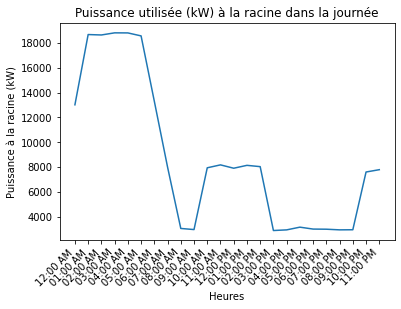

Première évaluation :  18815.566666666145
Somme =  210419.30000000692
1000000000.0
999000000.0
998001000.0
997002999.0
996005996.001
995009990.004999
994014980.014994
993020965.034979
992027944.069944
991035916.125874
990044880.2097481
989054835.3295383
988065780.4942088
987077714.7137146
986090636.9990009
985104546.3620019
984119441.8156399
983135322.3738242
982152187.0514504
981170034.864399
980188864.8295345
979208675.964705
978229467.2887403
977251237.8214515
976273986.5836301
975297712.5970465
974322414.8844495
973348092.469565
972374744.3770955
971402369.6327183
970430967.2630856
969460536.2958225
968491075.7595267
967522584.6837672
966555062.0990834
965588507.0369843
964622918.5299473
963658295.6114173
962694637.3158059
961731942.6784902
960770210.7358117
959809440.5250759
958849631.0845509
957890781.4534663
956932890.6720128
955975957.7813408
955019981.8235595
954064961.841736
953110896.8798943
952157785.9830143
951205628.1970314
950254422.5688343
949304168.1462655
948354863.97

627360994.3589777
626733633.3646187
626106899.731254
625480792.8315227
624855312.0386912
624230456.7266525
623606226.2699258
622982620.0436559
622359637.4236122
621737277.7861886
621115540.5084025
620494424.9678941
619873930.5429262
619254056.6123832
618634802.5557709
618016167.7532151
617398151.5854619
616780753.4338764
616163972.6804426
615547808.7077621
614932260.8990544
614317328.6381553
613703011.3095171
613089308.2982076
612476218.9899094
611863742.7709194
611251879.0281485
610640627.1491203
610029986.5219712
609419956.5354493
608810536.5789138
608201726.0423349
607593524.3162925
606985930.7919762
606378944.8611842
605772565.9163231
605166793.3504068
604561626.5570563
603957064.9304992
603353107.8655686
602749754.7577031
602147005.0029453
601544857.9979423
600943313.1399444
600342369.8268045
599742027.4569777
599142285.4295207
598543143.1440912
597944600.0009471
597346655.4009461
596749308.7455451
596152559.4367996
595556406.8773628
594960850.4704854
594365889.6200149
593771523.7

386557242.58898026
386170685.34639126
385784514.6610449
385398730.1463838
385013331.4162374
384628318.08482116
384243689.7667363
383859446.07696956
383475586.6308926
383092111.0442617
382709018.9332174
382326309.91428417
381943983.6043699
381562039.6207655
381180477.58114475
380799297.1035636
380418497.80646
380038079.30865353
379658041.2293449
379278383.18811554
378899104.8049274
378520205.7001225
378141685.4944224
377763543.80892795
377385780.265119
377008394.4848539
376631386.09036905
376254754.70427865
375878499.94957435
375502621.4496248
375127118.8281751
374751991.70934695
374377239.7176376
374002862.47791994
373628859.61544204
373255230.7558266
372881975.5250708
372509093.5495457
372136584.45599616
371764447.8715402
371392683.4236686
371021290.7402449
370650269.4495047
370279619.18005514
369909339.56087506
369539430.2213142
369169890.7910929
368800720.90030175
368431920.17940146
368063488.25922203
367695424.77096283
367327729.3461919
366960401.61684567
366593441.2152288
36622684

243239926.38991758
242996686.46352765
242753689.7770641
242510936.08728704
242268425.15119976
242026156.72604856
241784130.5693225
241542346.4387532
241300804.09231442
241059503.2882221
240818443.7849339
240577625.34114897
240337047.71580783
240096710.668092
239856613.95742393
239616757.3434665
239377140.58612302
239137763.44553688
238898625.68209136
238659727.05640927
238421067.32935286
238182646.2620235
237944463.6157615
237706519.1521457
237468812.63299358
237231343.82036057
236994112.4765402
236757118.36406368
236520361.2456996
236283840.88445392
236047557.04356948
235811509.4865259
235575697.97703937
235340122.27906233
235104782.15678328
234869677.3746265
234634807.69725186
234400172.8895546
234165772.71666503
233931606.94394836
233697675.33700442
233463977.6616674
233230513.68400574
232997283.17032173
232764285.88715142
232531521.60126427
232298990.079663
232066691.08958334
231834624.39849377
231602789.77409527
231371186.98432118
231139815.79733685
230908675.98153952
230677767.30

155839348.47946912
155683509.13098964
155527825.62185866
155372297.79623678
155216925.49844053
155061708.5729421
154906646.86436915
154751740.2175048
154596988.4772873
154442391.48881
154287949.09732118
154133661.14822385
153979527.48707563
153825547.95958856
153671722.41162896
153518050.68921733
153364532.6385281
153211168.1058896
153057956.9377837
152904898.9808459
152751994.08186504
152599242.0877832
152446642.8456954
152294196.20284972
152141902.00664687
151989760.10464022
151837770.3445356
151685932.57419106
151534246.64161688
151382712.39497527
151231329.6825803
151080098.3528977
150929018.2545448
150778089.23629025
150627311.14705396
150476683.8359069
150326207.152071
150175880.94491893
150025705.06397402
149875679.35891005
149725803.67955115
149576077.8758716
149426501.79799572
149277075.2961977
149127798.22090152
148978670.42268062
148829691.75225794
148680862.0605057
148532181.19844517
148383649.01724672
148235265.36822948
148087030.10286126
147938943.0727584
147791004.129685

100344123.39156725
100243779.26817568
100143535.4889075
100043391.9534186
99943348.56146517
99843405.21290371
99743561.8076908
99643818.2458831
99544174.42763722
99444630.25320958
99345185.62295637
99245840.4373334
99146594.59689607
99047448.00229917
98948400.55429688
98849452.15374258
98750602.70158884
98651852.09888725
98553200.24678837
98454647.04654159
98356192.39949505
98257836.20709555
98159578.37088846
98061418.79251757
97963357.37372506
97865394.01635133
97767528.62233497
97669761.09371264
97572091.33261894
97474519.24128632
97377044.72204503
97279667.67732298
97182388.00964566
97085205.621636
96988120.41601437
96891132.29559836
96794241.16330276
96697446.92213947
96600749.47521733
96504148.72574212
96407644.57701637
96311236.93243936
96214925.69550692
96118710.7698114
96022592.05904159
95926569.46698254
95830642.89751557
95734812.25461805
95639077.44236343
95543438.36492106
95447894.92655614
95352447.03162958
95257094.58459795
95161837.49001335
95066675.65252334
94971608.97687

62076366.96197419
62014290.59501222
61952276.30441721
61890324.02811279
61828433.70408468
61766605.270380594
61704838.665110216
61643133.8264451
61581490.69261866
61519909.201926045
61458389.29272412
61396930.90343139
61335533.97252796
61274198.43855543
61212924.24011687
61151711.31587675
61090559.604560874
61029469.04495631
60968439.57591136
60907471.13633545
60846563.66519911
60785717.10153391
60724931.384432375
60664206.453047946
60603542.2465949
60542938.7043483
60482395.765643954
60421913.36987831
60361491.45650843
60301129.96505192
60240828.83508687
60180588.00625178
60120407.41824553
60060287.01082729
60000226.72381646
59940226.49709264
59880286.27059555
59820405.984324954
59760585.57834063
59700824.99276229
59641124.16776953
59581483.04360176
59521901.560558155
59462379.658997595
1000
59402917.2793386
59343514.36205926
59284170.8476972
59224886.6768495
59165661.79017265
59106496.12838248
59047389.6322541
58988342.24262185
58929353.900379226
58870424.546478845
58811554.121932365

38210971.65598216
38172760.68432618
38134587.92364185
38096453.335718215
38058356.8823825
38020298.52550011
37982278.226974614
37944295.94874764
37906351.65279889
37868445.30114609
37830576.855844945
37792746.2789891
37754953.53271011
37717198.5791774
37679481.380598225
37641801.89921763
37604160.09731841
37566555.937221095
37528989.38128387
37491460.39190259
37453968.93151069
37416514.962579176
37379098.4476166
37341719.349168986
37304377.62981982
37267073.25219
37229806.17893781
37192576.37275887
37155383.796386115
37118228.41258973
37081110.18417714
37044029.07399296
37006985.04491897
36969978.05987405
36933008.08181418
36896075.07373236
36859178.99865863
36822319.81965997
36785497.49984031
36748712.00234047
36711963.290338136
36675251.327047795
36638576.07572075
36601937.49964503
36565335.56214539
36528770.22658324
36492241.45635666
36455749.2149003
36419293.4656854
36382874.17221971
36346491.29804749
36310144.80674944
36273834.66194269
36237560.827280745
36201323.26645347
36165121

23876328.617400352
23852452.28878295
23828599.836494166
23804771.23665767
23780966.465421014
23757185.498955593
23733428.313456636
23709694.88514318
23685985.190258037
23662299.20506778
23638636.90586271
23614998.268956847
23591383.27068789
23567791.8874172
23544224.095529784
23520679.871434253
23497159.19156282
23473662.032371257
23450188.370338887
23426738.181968547
23403311.44378658
23379908.132342793
23356528.22421045
23333171.695986237
23309838.524290252
23286528.685765963
23263242.157080196
23239978.914923117
23216738.936008193
23193522.197072186
23170328.674875114
23147158.34620024
23124011.18785404
23100887.176666185
23077786.28948952
23054708.503200028
23031653.794696826
23008622.140902128
22985613.518761225
22962627.905242465
22939665.277337223
22916725.612059887
22893808.88644783
22870915.077561382
22848044.162483823
22825196.11832134
22802370.92220302
22779568.551280815
22756788.982729536
22734032.193746805
22711298.16155306
22688586.863391507
22665898.276528116
22643232.37

15114565.495880019
15099450.930384139
15084351.479453754
15069267.1279743
15054197.860846326
15039143.66298548
15024104.519322494
15009080.414803172
14994071.334388368
14979077.26305398
14964098.185790926
14949134.087605136
14934184.95351753
14919250.768564012
14904331.517795447
14889427.186277652
14874537.759091375
14859663.221332284
14844803.55811095
14829958.75455284
14815128.795798287
14800313.667002488
14785513.353335485
14770727.83998215
14755957.112142168
14741201.155030025
14726459.953874996
14711733.493921122
14697021.760427201
14682324.738666775
14667642.413928108
14652974.771514181
14638321.796742667
14623683.474945923
14609059.791470977
14594450.731679505
14579856.280947825
14565276.424666878
14550711.148242211
14536160.43709397
14521624.276656875
14507102.652380219
14492595.549727838
14478102.95417811
14463624.85122393
14449161.226372708
14434712.065146334
14420277.353081187
14405857.075728105
14391451.218652377
14377059.767433725
14362682.70766629
14348320.024958625
14333

9529842.849870834
9520313.007020963
9510792.694013942
9501281.901319928
9491780.619418608
9482288.83879919
9472806.54996039
9463333.743410429
9453870.409667019
9444416.539257351
9434972.122718094
9425537.150595376
9416111.61344478
9406695.501831336
9397288.806329506
9387891.517523175
9378503.626005651
9369125.122379646
9359755.997257266
9350396.241260009
9341045.845018748
9331704.79917373
9322373.094374556
9313050.721280182
9303737.670558902
9294433.932888342
9285139.498955453
9275854.359456498
9266578.50509704
9257311.926591944
9248054.614665352
9238806.560050687
9229567.753490636
9220338.185737146
9211117.84755141
9201906.729703858
9192704.822974155
9183512.11815118
9174328.606033029
9165154.277426995
9155989.123149568
9146833.13402642
9137686.300892392
9128548.6145915
9119420.065976908
9110300.645910932
9101190.345265022
9092089.154919757
9082997.065764837
9073914.068699073
9064840.154630374
9055775.314475743
9046719.539161267
9037672.819622105
9028635.146802483
9019606.51165568
901

5942869.336553393
5936926.467216839
5930989.5407496225
5925058.551208873
5919133.492657664
5913214.359165006
5907301.144805841
5901393.843661035
5895492.449817374
5889596.957367557
5883707.360410189
5877823.653049779
5871945.829396729
5866073.883567332
5860207.809683765
5854347.601874081
5848493.254272208
5842644.761017935
5836802.116256918
5830965.314140661
5825134.34882652
5819309.214477694
5813489.905263216
5807676.415357953
5801868.738942595
5796066.870203652
5790270.803333449
5784480.532530116
5778696.051997586
5772917.355945589
5767144.438589644
5761377.294151054
5755615.916856903
5749860.300940046
5744110.440639106
5738366.330198467
5732627.963868269
5726895.335904401
5721168.4405684965
5715447.272127928
5709731.824855801
5704022.0930309445
5698318.070937914
5692619.752866976
5686927.133114109
5681240.205980995
5675558.965775014
5669883.406809239
5664213.523402429
5658549.309879026
5652890.760569148
5647237.869808579
5641590.63193877
5635949.041306832
5630313.092265525
5624682.7

3683829.7743523843
3680145.944578032
3676465.798633454
3672789.3328348203
3669116.5435019853
3665447.426958483
3661781.9795315247
3658120.197551993
3654462.0773544414
3650807.615277087
3647156.80766181
3643509.650854148
3639866.141203294
3636226.2750620907
3632590.0487870285
3628957.4587382413
3625328.501279503
3621703.1727782236
3618081.4696054454
3614463.3881358397
3610848.924747704
3607238.0758229564
3603630.8377471333
3600027.206909386
3596427.1797024766
3592830.752522774
3589237.9217702514
3585648.683848481
3582063.035164633
3578480.9721294683
3574902.491157339
3571327.5886661815
3567756.2610775153
3564188.5048164376
3560624.316311621
3557063.6919953097
3553506.6283033146
3549953.1216750112
3546403.168553336
3542856.7653847826
3539313.908619398
3535774.5947107784
3532238.820116068
3528706.5812959517
3525177.874714656
3521652.696839941
3518131.044143101
3514612.9130989583
3511098.300185859
3507587.201885673
3504079.6146837873
3500575.5350691034
3497074.959534034
3493577.8845745
349

2329663.316544614
2327333.653228069
2325006.3195748413
2322681.3132552663
2320358.631942011
2318038.273310069
2315720.2350367587
2313404.514801722
2311091.1102869203
2308780.0191766336
2306471.239157457
2304164.7679182994
2301860.6031503812
2299558.742547231
2297259.1838046834
2294961.924620879
2292666.962696258
2290374.2957335617
2288083.9214378283
2285795.8375163907
2283510.0416788743
2281226.5316371955
2278945.305105558
2276666.3598004524
2274389.693440652
2272115.303747211
2269843.1884434638
2267573.34525502
2265305.771909765
2263040.4661378553
2260777.4256717176
2258516.6482460457
2256258.1315977997
2254001.873466202
2251747.871592736
2249496.123721143
2247246.627597422
2244999.3809698243
2242754.3815888544
2240511.6272072657
2238271.1155800587
2236032.8444644785
2233796.8116200143
2231563.014808394
2229331.4517935854
2227102.120341792
2224875.01822145
2222650.1432032287
2220427.4930600254
2218207.0655669654
2215988.8585013985
2213772.869642897
2211559.096773254
2209347.537676481


1471811.7202465942
1470339.9085263475
1468869.5686178212
1467400.6990492034
1465933.2983501542
1464467.365051804
1463002.8976867523
1461539.8947890655
1460078.3548942765
1458618.2765393823
1457159.6582628428
1455702.49860458
1454246.7961059755
1452792.5493098695
1451339.7567605597
1449888.4170037992
1448438.5285867953
1446990.0900582084
1445543.0999681503
1444097.556868182
1442653.459311314
1441210.8058520027
1439769.5950461507
1438329.8254511047
1436891.4956256535
1435454.6041300278
1434019.1495258978
1432585.130376372
1431152.5452459957
1429721.3927007497
1428291.671308049
1426863.379636741
1425436.5162571042
1424011.0797408472
1422587.0686611063
1421164.4815924452
1419743.3171108528
1418323.5737937419
1416905.2502199481
1415488.3449697283
1414072.8566247586
1412658.7837681337
1411246.1249843657
1409834.8788593812
1408425.0439805218
1407016.6189365413
1405609.6023176047
1404203.992715287
1402799.7887225717
1401396.9889338491
1399995.5919449152
1398595.5963529702
1397197.0007566172
13

934509.9107280654
933575.4008173373
932641.82541652
931709.1835911035
930777.4744075125
929846.696933105
928916.8502361719
927987.9333859357
927059.9454525498
926132.8855070974
925206.7526215903
924281.5458689687
923357.2643230997
922433.9070587767
921511.4731517179
920589.9616785662
919669.3717168876
918749.7023451707
917830.9526428255
916913.1216901827
915996.2085684926
915080.2123599241
914165.1321475642
913250.9670154166
912337.7160484012
911425.3783323528
910513.9529540205
909603.4390010665
908693.8355620655
907785.1417265034
906877.3565847769
905970.4792281921
905064.5087489639
904159.444240215
903255.2847959747
902352.0295111787
901449.6774816676
900548.2278041859
899647.6795763818
898748.0318968054
897849.2838649086
896951.4345810437
896054.4831464626
895158.4286633162
894263.2702346529
893369.0069644182
892475.6379574538
891583.1623194964
890691.5791571769
889800.8875780198
888911.0866904417
888022.1756037512
887134.1534281474
886247.0192747193
885360.7722554445
884475.4114831

590395.4573728745
589805.0619155016
589215.2568535861
588626.0415967325
588037.4155551357
587449.3781395806
586861.928761441
586275.0668326796
585688.7917658469
585103.1029740811
584517.9998711069
583933.4818712359
583349.5483893646
582766.1988409753
582183.4326421344
581601.2492094922
581019.6479602827
580438.6283123224
579858.1896840101
579278.3314943261
578699.0531628318
578120.354109669
577542.2337555593
576964.6915218037
576387.7268302819
575811.3391034516
575235.5277643481
574660.2922365838
574085.6319443472
573511.5463124028
572938.0347660905
572365.0967313243
571792.731634593
571220.9389029584
570649.7179640555
570079.0682460915
569508.9891778454
568939.4801886675
568370.5407084789
567802.1701677704
567234.3679976026
566667.1336296049
566100.4664959754
565534.3660294794
564968.83166345
564403.8628317865
563839.4589689547
563275.6195099858
562712.3438904758
562149.6315465854
561587.4819150388
561025.8944331238
560464.8685386906
559904.403670152
559344.4992664818
558785.154767215

374489.9352107824
374115.4452755716
373741.32983029605
373367.58850046573
372994.22091196524
372621.22669105325
372248.6054643622
371876.35685889784
371504.48050203896
371132.9760215369
370761.84304551536
370391.0812024698
370020.69012126734
369650.66943114606
369281.0187617149
368911.7377429532
368542.8260052102
368174.283179205
367806.1088960258
367438.30278712977
367070.86448434263
366703.7936198583
366337.0898262384
365970.75273641216
365604.7819836757
365239.1772016921
364873.9380244904
364509.06408646586
364144.5550223794
363780.410467357
363416.63005688967
363053.2134268328
362690.16021340596
362327.4700531926
361965.14258313936
361603.17744055623
361241.57426311565
360880.3326888525
360519.45235616365
360158.9329038075
359798.7739709037
359438.9751969328
359079.5362217359
358720.45668551413
358361.7362288286
358003.3744925998
357645.3711181072
357287.72574698913
356930.43802124215
356573.5075832209
356216.93407563766
355860.717141562
355504.8564244205
355149.3515679961
354794.2

236591.55889321034
236354.96733431713
236118.61236698282
235882.49375461583
235646.61126086122
235410.96464960036
235175.55368495075
234940.3781312658
234705.43775313455
234470.7323153814
234236.26158306602
234002.02532148294
233768.02329616147
233534.2552728653
233300.72101759244
233067.42029657486
232834.35287627828
232601.518523402
232368.91700487857
232136.5480878737
231904.41153978583
231672.50712824604
231440.8346211178
231209.3937864967
230978.1843927102
230747.20620831748
230516.45900210916
230285.94254310706
230055.65660056396
229825.6009439634
229595.77534301943
229366.17956767642
229136.81338810874
228907.67657472062
228678.7688981459
228450.09012924775
228221.6400391185
227993.41839907938
227765.4249806803
227537.65955569962
227310.12189614392
227082.81177424776
226855.7289624735
226628.87323351103
226402.24436027752
226175.84211591724
225949.66627380133
225723.71660752752
225497.99289092
225272.49489802908
225047.22240313105
224822.1751807279
224597.3530055472
224372.75565

150974.45109163458
150823.47664054294
150672.6531639024
150521.9805107385
150371.45853022777
150221.08707169755
150070.86598462585
149920.79511864122
149770.87432352258
149621.10344919906
149471.48234574986
149322.0108634041
149172.6888525407
149023.51616368818
148874.4926475245
148725.61815487695
148576.89253672207
148428.31564418535
148279.88732854117
148131.60744121263
147983.47583377143
147835.49235793765
147687.65686557972
147539.96920871414
147392.42923950544
147245.03681026594
147097.79177345568
146950.69398168224
146803.74328770055
146656.93954441286
146510.28260486844
146363.77232226357
146217.4085499413
146071.19114139135
145925.11995024997
145779.1948302997
145633.4156354694
145487.78221983393
145342.2944376141
145196.9521431765
145051.7551910333
144906.70343584227
144761.79673240642
144617.03493567402
144472.41790073834
144327.9454828376
144183.61753735476
144039.4339198174
143895.3944858976
143751.49909141168
143607.74759232026
143464.13984472794
143320.6757048832
143177.3

96629.82835060137
96533.19852225076
96436.66532372852
96340.2286584048
96243.8884297464
96147.64454131665
96051.49689677534
95955.44539987856
95859.48995447869
95763.6304645242
95667.86683405968
95572.19896722562
95476.62676825839
95381.15014149013
95285.76899134864
95190.48322235729
95095.29273913494
95000.1974463958
94905.19724894941
94810.29205170045
94715.48175964876
94620.76627788911
94526.14551161122
94431.6193660996
94337.18774673351
94242.85055898679
94148.6077084278
94054.45910071937
93960.40464161865
93866.44423697703
93772.57779274005
93678.80521494731
93585.12640973236
93491.54128332263
93398.04974203931
93304.65169229727
93211.34704060497
93118.13569356437
93025.0175578708
92931.99254031293
92839.06054777262
92746.22148722484
92653.47526573762
92560.82179047189
92468.26096868142
92375.79270771274
92283.41691500503
92191.13349809003
92098.94236459195
92006.84342222735
91914.83657880512
91822.92174222632
91731.0988204841
91639.36772166361
91547.72835394194
91456.18062558801


60621.78519877075
60561.16341357198
60500.60225015841
60440.10164790825
60379.66154626034
60319.28188471407
60258.96260282936
60198.70364022653
60138.5049365863
60078.366431649716
60018.28806521807
59958.26977715285
59898.31150737569
59838.413195868314
59778.57478267245
59718.796207889776
59659.07741168189
59599.4183342702
59539.81891593593
59480.27909701999
59420.79881792297
59361.37801910505
59302.01664108594
59242.71462444485
59183.47190982041
59124.28843791059
59065.16414947268
59006.09898532321
58947.09288633789
58888.14579345155
58829.257647658094
58770.428390010435
58711.657961620425
58652.946303658806
58594.29335735515
58535.699063997796
58477.1633649338
58418.68620156886
58360.26751536729
58301.90724785192
58243.605340604074
58185.36173526347
58127.17637352821
58069.04919715468
58010.980147957525
57952.96916780957
57895.01619864176
57837.121182443116
57779.284061260674
57721.504777199414
57663.78327242222
57606.119489149794
57548.51336966064
57490.96485629098
57433.47389143469

38260.73470396135
38222.47396925739
38184.25149528813
38146.067243792844
38107.921176549055
38069.81325537251
38031.743442117135
37993.71169867502
37955.71798697634
37917.76226898937
37879.84450672038
37841.96466221366
37804.122697551444
37766.31857485389
37728.552256279036
37690.823704022754
37653.13288031873
37615.47974743841
37577.86426769097
37540.286403423284
37502.74611701986
37465.24337090284
37427.778127531936
37390.350349404405
37352.959999055
37315.60703905594
37278.291432016886
37241.013140584866
37203.77212744428
37166.568355316835
37129.40178696152
37092.27238517456
37055.180112789385
37018.1249326766
36981.10680774392
36944.12570093617
36907.181575235234
36870.27439366
36833.40411926634
36796.57071514708
36759.77414443193
36723.0143702875
36686.29135591721
36649.60506456129
36612.955459496734
36576.34250403724
36539.7661615332
36503.22639537167
36466.7231689763
36430.256445807325
36393.82618936152
36357.432363172156
36321.07493080899
36284.75385587818
36248.4691020223
362

24075.446706637515
24051.37125993088
24027.319888670947
24003.292568782275
23979.289276213494
23955.30998693728
23931.354676950345
23907.423322273393
23883.51589895112
23859.63238305217
23835.772750669115
23811.936977918445
23788.125040940526
23764.336915899585
23740.572578983683
23716.8320064047
23693.115174398295
23669.422059223896
23645.75263716467
23622.106884527508
23598.48477764298
23574.88629286534
23551.311406572473
23527.7600951659
23504.232335070734
23480.728102735662
23457.247374632927
23433.790127258293
23410.356337131034
23386.945980793902
23363.559034813108
23340.195475778295
23316.855280302516
23293.538425022212
23270.24488659719
23246.974641710593
23223.72766706888
23200.503939401813
23177.30343546241
23154.126132026948
23130.97200589492
23107.841033889024
23084.733192855136
23061.64845966228
23038.58681120262
23015.548224391416
22992.532676167026
22969.54014349086
22946.57060334737
22923.62403274402
22900.700408711276
22877.799708302566
22854.921908594264
22832.0669866

15471.062829777522
15455.591766947744
15440.136175180796
15424.696039005616
15409.27134296661
15393.862071623642
15378.468209552018
15363.089741342466
15347.726651601124
15332.378924949522
15317.046546024572
15301.729499478548
15286.42776997907
15271.14134220909
15255.87020086688
15240.614330666014
15225.373716335349
15210.148342619013
15194.938194276394
15179.743256082118
15164.563512826036
15149.39894931321
15134.249550363897
15119.115300813533
15103.99618551272
15088.892189327207
15073.80329713788
15058.729493840741
15043.6707643469
15028.627093582552
15013.59846648897
14998.58486802248
14983.586283154458
14968.602696871303
14953.634094174431
14938.680460080257
14923.741779620177
14908.818037840558
14893.909219802717
14879.015310582914
14864.13629527233
14849.272158977057
14834.42288681808
14819.588463931263
14804.76887546733
14789.964106591864
14775.174142485272
14760.398968342786
14745.638569374443
14730.892930805068
14716.162037874263
14701.445875836389
14686.744429960552
14672.0

9971.706356411167
9961.734650054756
9951.772915404701
9941.821142489296
9931.879321346807
9921.947442025461
9912.025494583435
9902.113469088852
9892.211355619764
9882.319144264144
9872.43682511988
9862.564388294759
9852.701823906464
9842.849122082558
9833.006272960476
9823.173266687516
9813.350093420828
9803.536743327408
9793.73320658408
9783.939473377495
9774.155533904117
9764.381378370213
9754.616996991843
9744.862379994851
9735.117517614855
9725.38240009724
9715.657017697144
9705.941360679446
9696.235419318766
9686.539183899447
9676.852644715547
9667.175792070831
9657.508616278761
9647.851107662482
9638.20325655482
9628.565053298265
9618.936488244966
9609.317551756722
9599.708234204965
9590.10852597076
9580.51841744479
9570.937899027345
9561.366961128319
9551.80559416719
9542.253788573023
9532.71153478445
9523.178823249666
9513.655644426415
9504.141988781988
9494.637846793206
9485.143208946412
9475.658065737465
9466.182407671728
9456.716225264056
9447.259509038791
9437.812249529752


6243.354151843037
6237.1107976911935
6230.873686893502
6224.6428132066085
6218.418170393402
6212.1997522230085
6205.987552470786
6199.781564918315
6193.5817833533965
6187.388201570043
6181.200813368473
6175.019612555105
6168.84459294255
6162.675748349608
6156.513072601258
6150.356559528656
6144.206202969128
6138.061996766159
6131.923934769393
6125.792010834623
6119.666218823789
6113.546552604965
6107.43300605236
6101.325573046307
6095.224247473261
6089.129023225788
6083.039894202562
6076.95685430836
6070.879897454051
6064.809017556598
6058.744208539041
6052.685464330502
6046.632778866172
6040.586146087306
6034.545559941218
6028.511014381277
6022.482503366896
6016.460020863529
6010.443560842666
6004.433117281823
5998.428684164541
5992.430255480376
5986.437825224896
5980.451387399671
5974.4709360122715
5968.4964650762595
5962.5279686111835
5956.565440642572
5950.60887520193
5944.658266326727
5938.7136080604005
5932.77489445234
5926.842119557888
5920.91527743833
5914.994362160892
5909.079

3897.2918137112174
3893.3945218975064
3889.501127375609
3885.6116262482333
3881.726014621985
3877.844288607363
3873.9664443187557
3870.092477874437
3866.2223853965625
3862.356163011166
3858.4938068481547
3854.6353130413067
3850.7806777282653
3846.929897050537
3843.0829671534866
3839.2398841863333
3835.4006443021467
3831.5652436578443
3827.7336784141867
3823.9059447357727
3820.0820387910367
3816.2619567522456
3812.445694795493
3808.633249100698
3804.824615851597
3801.0197912357457
3797.21877144451
3793.4215526730654
3789.6281311203925
3785.838502989272
3782.0526644862825
3778.270611821796
3774.4923412099743
3770.717848868764
3766.9471310198956
3763.1801838888755
3759.4170037049867
3755.6575867012816
3751.9019291145805
3748.150027185466
3744.4018771582805
3740.657475281122
3736.9168178058408
3733.179900988035
3729.446721087047
3725.71727436596
3721.9915570915937
3718.269565534502
3714.551295968967
3710.836744672998
3707.125907928325
3703.4187820203965
3699.715363238376
3696.015647875138


2479.4970926789697
2477.0175955862906
2474.540577990704
2472.0660374127133
2469.5939713753005
2467.1243774039253
2464.6572530265216
2462.192595773495
2459.7304031777217
2457.270672774544
2454.8134021017695
2452.3585886996675
2449.906230110968
2447.456323880857
2445.008867556976
2442.563858689419
2440.1212948307293
2437.681173535899
2435.2434923623628
2432.80824887
2430.37544062113
2427.945065180509
2425.5171201153285
2423.091602995213
2420.668511392218
2418.247842880826
2415.829595037945
2413.4137654429073
2411.0003516774646
2408.589351325787
2406.1807619744613
2403.7745812124867
2401.3708066312743
2398.969435824643
2396.570466388818
2394.1738959224294
2391.779722026507
2389.3879423044805
2386.998554362176
2384.611555807814
2382.2269442520064
2379.8447173077543
2377.4648725904467
2375.0874077178564
2372.7123203101387
2370.3396079898284
2367.9692683818384
2365.6012991134567
2363.235697814343
2360.872462116529
2358.511589654412
2356.1530780647577
2353.796924986693
2351.443128061706
2349.

1568.0402662766103
1566.4722260103338
1564.9057537843235
1563.340848030539
1561.7775071825085
1560.215729675326
1558.6555139456507
1557.096858431705
1555.5397615732732
1553.9842218116999
1552.430237589888
1550.877807352298
1549.3269295449459
1547.7776026154008
1546.2298250127853
1544.6835951877727
1543.138911592585
1541.5957726809922
1540.0541769083113
1538.514122731403
1536.9756086086716
1535.438633000063
1533.903194367063
1532.369291172696
1530.8369218815233
1529.3060849596418
1527.7767788746821
1526.2490020958073
1524.7227530937116
1523.1980303406178
1521.6748323102772
1520.153157477967
1518.633004320489
1517.1143713161684
1515.5972569448522
1514.0816596879074
1512.5675780282195
1511.0550104501913
1509.543955439741
1508.0344114843012
1506.526377072817
1505.0198506957443
1503.5148308450484
1502.0113160142034
1500.5093046981892
1499.008795393491
1497.5097865980974
1496.0122768114993
1494.5162645346877
1493.021748270153
1491.5287265218828
1490.037197795361
1488.5471605975656
1487.05861

988.660727558393
987.6720668308346
986.6843947640039
985.6977103692399
984.7120126588707
983.7273006462118
982.7435733455656
981.76082977222
980.7790689424477
979.7982898735053
978.8184915836317
977.8396730920481
976.861833418956
975.8849715855371
974.9090866139516
973.9341775273376
972.9602433498103
971.9872831064605
971.015295823354
970.0442805275306
969.0742362470031
968.1051620107561
967.1370568487454
966.1699197918966
965.2037498721047
964.2385461222326
963.2743075761103
962.3110332685343
961.3487222352658
960.3873735130305
959.4269861395175
958.4675591533779
957.5090915942245
956.5515825026303
955.5950309201277
954.6394358892076
953.6847964533183
952.731111656865
951.7783805452082
950.826602164663
949.8757755624983
948.9258997869358
947.9769738871489
947.0289969132617
946.0819679163485
945.1358859484321
944.1907500624837
943.2465593124213
942.3033127531088
941.3610094403557
940.4196484309153
939.4792287824845
938.539749553702
937.6012098041483
936.6636085943442
935.7269449857498


623.3577384701304
622.7343807316603
622.1116463509286
621.4895347045776
620.8680451698731
620.2471771247032
619.6269299475784
619.0073030176309
618.3882957146133
617.7699074188987
617.1521375114799
616.5349853739684
615.9184503885945
615.3025319382059
614.6872294062676
614.0725421768614
613.4584696346845
612.8450111650499
612.2321661538848
611.619933987731
611.0083140537432
610.3973057396895
609.7869084339499
609.1771215255159
608.5679444039904
607.9593764595865
607.3514170831269
606.7440656660438
606.1373216003777
605.5311842787773
604.9256530944986
604.3207274414041
603.7164067139627
603.1126903072487
602.5095776169414
601.9070680393245
601.3051609712852
600.7038558103139
600.1031519545036
599.5030488025491
598.9035457537465
598.3046422079927
597.7063375657848
597.108631228219
596.5115225969907
595.9150110743938
595.3190960633194
594.7237769672561
594.1290531902888
593.5349241370985
592.9413892129614
592.3484478237485
591.7560993759248
591.1643432765488
590.5731789332723
589.98260575

1000
394.6076265093848
394.21301888287536
393.8188058639925
393.4249870581285
393.03156207107037
392.6385305089993
392.2458919784903
391.8536460865118
391.46179244042526
391.0703306479848
390.6792603173368
390.2885810570195
389.8982924759625
389.50839418348653
389.118885789303
388.72976690351373
388.3410371366102
1000
387.9526960994736
387.5647434033741
387.1771786599707
386.79000148131075
386.40321147982945
386.0168082683496
385.6307914600813
385.2451606686212
384.8599155079526
384.4750555924447
384.09058053685226
383.7064899563154
383.3227834663591
382.93946068289273
382.5565212222098
382.1739647009876
381.7917907362866
381.4099989455503
381.0285889466047
380.6475603576581
380.26691279730045
379.88664588450314
379.50675923861866
379.12725247938005
378.74812522690064
378.36937710167376
377.9910077245721
377.61301671684754
377.2354037001307
376.85816829643056
376.4813101281341
376.10482881800596
375.7287239891879
375.35299526519873
374.97764226993354
374.6026646276636
374.2280619630359

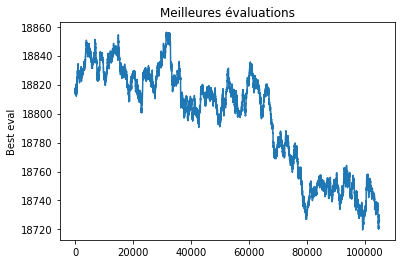

Dernière évaluation :  18725.91666666646
Somme =  210419.30000000735


In [25]:
best_x, best_evaluation, sum_by_hour = PASA1(T0, IterMax, Tmin, Palier, Alpha, lst_index_logement, new_dict_HC, df_equipments_short, df_info_consumption, lst_col_equipment)

In [26]:
print(best_evaluation)

18725.91666666646


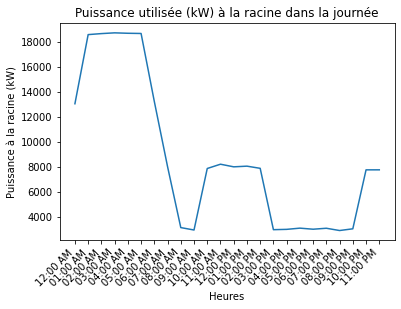

[13051.7        18585.31666667 18665.96666667 18725.91666667
 18692.26666667 18675.81666667 13233.06666667  8022.
  3141.6         2947.95        7870.85        8213.4
  8003.65        8057.65        7884.5         2974.35
  2999.95        3096.85        3011.65        3088.4
  2906.75        3044.1         7762.25        7763.35      ]


In [27]:
# Générer un premier dictionnaire de matrice et déterminer la somme de chaque
y = list(sum_by_hour)
x = [datetime.time(i).strftime("%I:00 %p") for i in range(0, 24)]

create_fig(x, y)  
print(sum_by_hour)

In [28]:
pd.set_option('display.max_column', None)
display(best_x['A100-3-1'])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
LV,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.3,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0
LL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0
SL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.25,0.25,0.25,0.0,0.0,0.0
TV,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0
FG1,0.000000,0.000000,0.100000,0.100000,0.000000,0.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0
CE1,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0
FO,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,1.6,0.0
PL,0.000000,0.000000,0.000000,1.200000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0
FG2,0.000000,0.000000,0.000000,0.000000,0.300000,0.000000,0.0,0.3,0.0,0.0,0.0,0.3,0.0,0.3,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0
CE2,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0


In [31]:
best_x['A100-3-1'].to_csv('louve.csv', sep=',', encoding='utf-8') #sep=',')

In [34]:
res = {"x" : x, "y" : y, "type" : "scatter", "marker" : "lines+markers"}
# Serializing json  
import json
json_object = json.dumps(res)
print(json_object)

{"x": ["12:00 AM", "01:00 AM", "02:00 AM", "03:00 AM", "04:00 AM", "05:00 AM", "06:00 AM", "07:00 AM", "08:00 AM", "09:00 AM", "10:00 AM", "11:00 AM", "12:00 PM", "01:00 PM", "02:00 PM", "03:00 PM", "04:00 PM", "05:00 PM", "06:00 PM", "07:00 PM", "08:00 PM", "09:00 PM", "10:00 PM", "11:00 PM"], "y": [13051.7000000014, 18585.316666666433, 18665.96666666659, 18725.91666666646, 18692.266666666546, 18675.81666666628, 13233.066666668074, 8022.00000000078, 3141.600000000039, 2947.950000000027, 7870.850000000636, 8213.400000000622, 8003.650000000568, 8057.650000000682, 7884.500000000657, 2974.350000000022, 2999.950000000036, 3096.8500000000336, 3011.6500000000274, 3088.400000000023, 2906.7500000000255, 3044.1000000000327, 7762.250000000702, 7763.350000000655], "type": "scatter", "marker": "lines+markers"}
